# BASIC IMPORTS
-----------------------------

In [1]:
import jax
import jax.numpy as jnp
from PIL.ImageChops import offset
from jax import grad, jit, vmap
from jax import random

import matplotlib.pyplot as plt

import numpy as np
from qtconsole.mainwindow import background
from scipy.stats import alpha
from zmq import WSS_KEY_PEM

from Utils.models import *
from Utils.simulation import *
from Utils.plot_utils import *

import time
from copy import copy


%load_ext autoreload
%autoreload 2

In [2]:

jax.config.update("jax_platform_name", "cpu")  # Force CPU usage
# #
print(jax.devices())  # Should show only CpuDevice



[CpuDevice(id=0)]


In [3]:
params_dict = {
    "dataset_parameters": {
        "n_samples": 200
    },
    "network_parameters": {
        "input_size": 64,
        "hidden_size": 128,
        "output_size": 1,
        "bias": 1,
    },
    "training_parameters": {
        "num_epochs": 100,
        "learning_rate": 0.1
    },
    "simulation_parameters": {
        "mu": 1,
        "sigma": 0.1,
        "theta": 0.05,
        "dt": 0.001,
        "tau": 0.002
    },
    "seed": 42
}

# set the random key
rng = random.PRNGKey(params_dict["seed"])


# ELM
---------------------------

We set up a basic 2-layer neural network (Extreme Learning Machine, ELM).

In [4]:
# mean and sigma of the lognormal distribution from the paramaters
mu_LN = mu_LN_from_params(**params_dict["simulation_parameters"])
sigma_LN = sigma_LN_from_params(**params_dict["simulation_parameters"])

#initialize the 2 layer ELM
rng, net_key = random.split(rng)
params = init_elm(net_key, mu_LN, sigma_LN, **params_dict["network_parameters"])

In [5]:
simulation_parameters = params_dict["simulation_parameters"]

print(simulation_parameters)
print("mu_LN: ", mu_LN, "sigma_LN: ", sigma_LN)

print(np.exp(mu_LN + sigma_LN**2/2))




{'mu': 1, 'sigma': 0.1, 'theta': 0.05, 'dt': 0.001, 'tau': 0.002}
mu_LN:  -0.052680295 sigma_LN:  0.32459292
1.0


In [6]:
params.keys()

dict_keys(['W_i', 'W_o', 'b_i', 'b_o', 'bias'])

mean:  1.0040162 var:  0.10802924


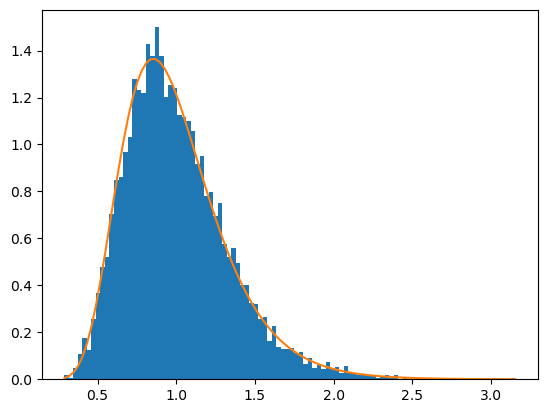

In [7]:


W_i_0 = params['W_i']

print('mean: ', jnp.mean(W_i_0), 'var: ', jnp.var(W_i_0))

# histogram of the parameters
plt.hist(W_i_0.flatten(), bins=100, density=True)
# plot the lognormal distribution on top
x = np.linspace(jnp.min(W_i_0), jnp.max(W_i_0), 100)
y = lognormal_distribution(x, mu_LN, sigma_LN)
plt.plot(x, y)
plt.show()

# Evolution of the Weights
------------------------------

Here we let the weigh evolve over time using GOU process and see what happens


In [8]:
# simulate perturbations of the weights of W_i
simulation_parameters = params_dict["simulation_parameters"]
rng, sim_key = random.split(rng)
weight_list_GOU = simulate_perturbation_only(sim_key, params['W_i'].flatten(), 10000, simulation_parameters['mu']
                                             , simulation_parameters['theta']
                                             , simulation_parameters['sigma'], simulation_parameters['dt'])


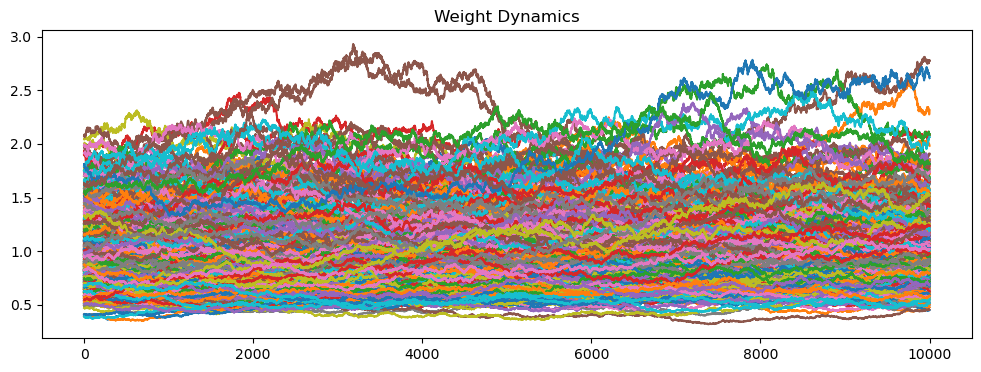

In [9]:
# plot some weights
plot_weight_dynamics(weight_list_GOU, title="Weight Dynamics", weights_to_show=500, show=True)

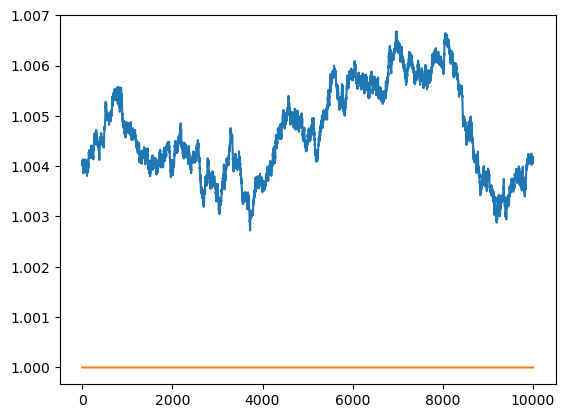

In [10]:
#plot the evolution of the mean
mean_weight = np.mean(weight_list_GOU, axis=1)
plt.plot(mean_weight)
plt.plot([np.exp(mu_LN + sigma_LN**2/2)]*len(mean_weight))
#plot the evolution of the variance
var_weight = np.var(weight_list_GOU, axis=1)
# plt.gca().twinx().plot(var_weight)
# plt.legend(["mean", "variance"])
plt.show()

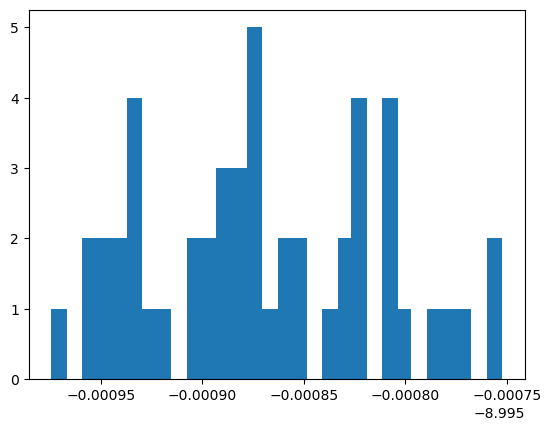

In [11]:
plt.hist(weight_list_GOU[-50:].mean(axis=1)-10, bins=30)
plt.show()

We now check that the weights are lognormally distributed after the evolution

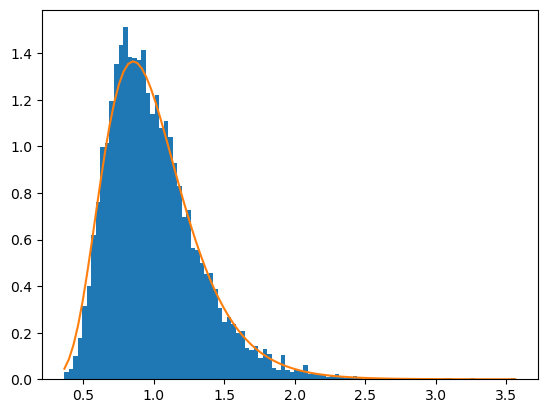

In [12]:
W_after_evol = weight_list_GOU[-1]
plt.hist(W_after_evol, bins=100, density=True)
# plot the lognormal distribution on top
x = np.linspace(jnp.min(W_after_evol), jnp.max(W_after_evol), 100)
y = lognormal_distribution(x, mu_LN, sigma_LN)
plt.plot(x, y)
plt.show()

# TRAINING
---------------------------------

now we train the network

In [13]:
rng, data_key = random.split(rng)

X_train, y_train = create_binary_dataset(data_key,
                                         n_samples=params_dict["dataset_parameters"]["n_samples"],
                                         input_dim=params_dict["network_parameters"]["input_size"])

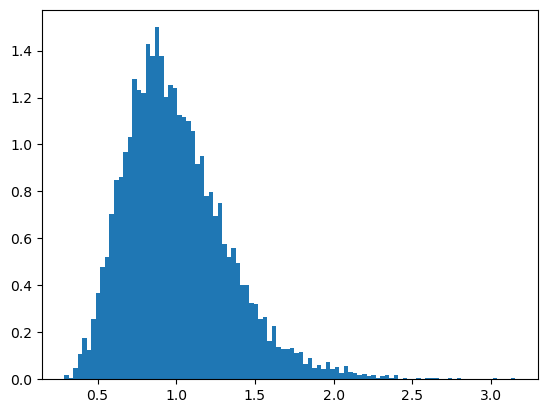

In [14]:
plt.hist(params["W_i"].flatten(), bins = 100, density = True)
plt.show()

In [15]:

loss_list = []
acc_list = []
grad_list = []
grad_list_RO = []

training_parameters = params_dict["training_parameters"]
num_epochs = training_parameters["num_epochs"]
learning_rate = training_parameters["learning_rate"]

weight_list = []

#simulation_parameters['sigma'] = 0
simulation_parameters['theta'] = 0


for epoch in range(num_epochs):
    start_time = time.time()
    for x,y in zip(X_train,y_train):

        rng, gou_key = random.split(rng)
        #perturb the weights of W_i
        params['W_i'] = time_evolution_GOU(gou_key, params['W_i'], **simulation_parameters)

        grads = grad(loss_elm)(params, x, y)
        params['W_i'] -= learning_rate * grads['W_i']
        params['W_o'] -= learning_rate * grads['W_o']
        params['b_i'] -= learning_rate * grads['b_i']
        params['b_o'] -= learning_rate * grads['b_o']

        #grad_list_RO.append(grads['W_o'].flatten())
        #grad_list.append(grads['W_i'].flatten())
        weight_list.append(params['W_i'].flatten())

    acc_list.append(accuracy_elm(params, X_train, y_train))
    loss_list.append(loss_elm(params, X_train, y_train))


    if epoch%10==0:
        epoch_time = time.time() - start_time
        train_loss = loss_elm(params, X_train, y_train)
        train_acc = accuracy_elm(params, X_train, y_train)
        print("Epoch {} in {:0.2f} sec".format(epoch, epoch_time))
        print("Training set loss {}".format(train_loss))
        print("Training set accuracy {}".format(train_acc))

Epoch 0 in 2.07 sec
Training set loss 1.1677969694137573
Training set accuracy 0.550000011920929
Epoch 10 in 0.75 sec
Training set loss 0.16802184283733368
Training set accuracy 0.9199999570846558
Epoch 20 in 0.74 sec
Training set loss 0.061335280537605286
Training set accuracy 0.9899999499320984
Epoch 30 in 0.72 sec
Training set loss 0.027503933757543564
Training set accuracy 1.0
Epoch 40 in 0.75 sec
Training set loss 0.03392341732978821
Training set accuracy 1.0
Epoch 50 in 0.74 sec
Training set loss 0.014463216997683048
Training set accuracy 1.0
Epoch 60 in 0.80 sec
Training set loss 0.014363555237650871
Training set accuracy 1.0
Epoch 70 in 0.82 sec
Training set loss 0.013122998178005219
Training set accuracy 1.0
Epoch 80 in 0.78 sec
Training set loss 0.008745812810957432
Training set accuracy 1.0
Epoch 90 in 0.83 sec
Training set loss 0.010239865630865097
Training set accuracy 1.0


In [16]:
import os
os.getcwd()

'/home/pietroverzelli/Projects/changing_synapses/Notebooks'

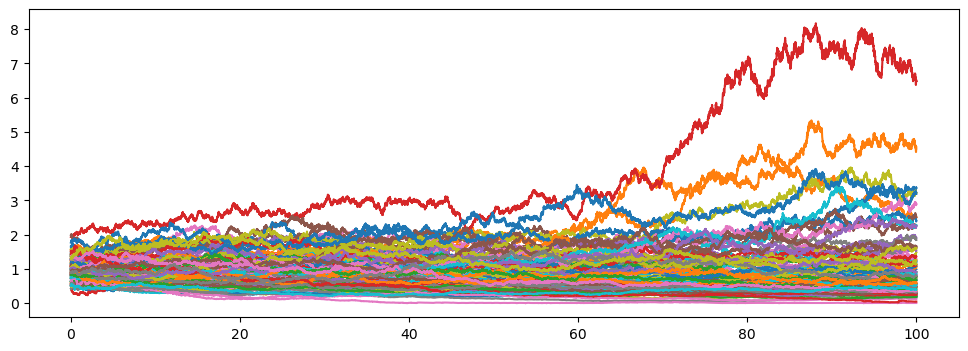

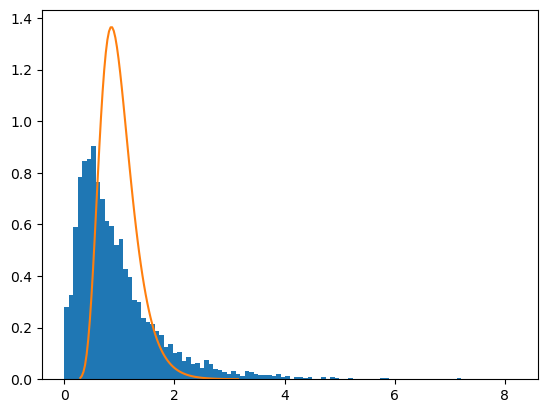

In [17]:
name = "weights_sigma_only"
w_list = np.array(weight_list)[:, :100]
plt.figure(figsize=(12, 4))
plt.plot(np.arange(len(w_list))/200, w_list)
plt.savefig(name+".png", dpi=3000)
plt.show()

plt.hist(np.array(weight_list)[-1,:], bins=100, density=True)
x = np.linspace(jnp.min(W_i_0), jnp.max(W_i_0), 100)
y = lognormal_distribution(x, mu_LN, sigma_LN)
plt.plot(x, y)
plt.savefig("hist_"+name+".png", dpi = 3000)
plt.show()

In [18]:
np.array(weight_list).shape

(20000, 8192)

In [19]:
# plt.hist(np.array(weight_list)[-1,:], bins=100, density=True)
# x = np.linspace(jnp.min(W_i_0), jnp.max(W_i_0), 100)
# y = lognormal_distribution(x, mu_LN, sigma_LN)
# plt.plot(x, y)
# plt.savefig("hist_weights")
# plt.show()

In [20]:
plt.plot(np.mean(np.abs(np.array(grad_list)[:,:100]), axis =1))
plt.show()

IndexError: too many indices for array: array is 1-dimensional, but 2 were indexed

In [ ]:
plt.plot(np.mean(np.abs(np.array(grad_list_RO)[:,:100]), axis = 1))
plt.show()

In [ ]:
#plot the evolution of the mean
mean_weight = np.mean(weight_list, axis=1)
plt.plot(mean_weight)
#plot the evolution of the variance
var_weight = np.var(weight_list, axis=1)
plt.gca().twinx().plot(var_weight)
plt.legend(["mean", "variance"])
plt.show()

In [ ]:

plt.hist(weight_list, bins=100, density=True)
# plot the lognormal distribution on top
x = np.linspace(jnp.min(W_after_evol), jnp.max(W_after_evol), 100)
y = lognormal_distribution(x, mu_LN, sigma_LN)
plt.plot(x, y)
plt.show()